In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma
import matplotlib
cm = matplotlib.cm.get_cmap('jet')

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from tqdm import tqdm

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

from lsst.rsp import get_tap_service, retrieve_query
service = get_tap_service()

from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from tqdm import tqdm 
from astropy.table import Table

In [149]:
# create the TAP service client
service = get_tap_service()

# we will all use the same input coordinates and radii
center_coords = "62, -32"

radius_deg = 1 # degrees

## Scope

1. Generate a list of DiaObjects and examine their time series features
2. Take diaObjectID and fetch the DiaSource information. We will be examining two kinds of flux measurements:
    1. psFlux -- calibrated flux for the difference images: template - science 
    2. totFlux (force photometry) -- calibrated flux model for point souce on the average position of source based on the difference images
    
3. Fetch light curves
4. Explore


In [150]:
rad = 1.3 # radius of cone search

results = service.search("SELECT ra, decl, gPSFluxSigma, rPSFluxSigma, nDiaSources, diaObjectId, "
                         "uPSFluxNdata, gPSFluxNdata, rPSFluxNdata, iPSFluxNdata, zPSFluxNdata, yPSFluxNdata, rPSFluxMax, "
                         "scisql_nanojanskyToAbMag(uPSFluxMax) as u_psf_mag, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) as g_psf_mag, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) as r_psf_mag, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) as i_psf_mag, "
                         "scisql_nanojanskyToAbMag(zPSFluxMax) as z_psf_mag, "
                         "scisql_nanojanskyToAbMag(yPSFluxMax) as y_psf_mag "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {rad})) = 1 "
                        "AND uPSFluxChi2 > 0 "
                        "AND gPSFluxChi2 > 0 "
                        "AND rPSFluxChi2 > 0 "
                        "AND iPSFluxChi2 > 0 "
                        "AND zPSFluxChi2 > 0 "
                        "AND yPSFluxChi2 > 0 ")

table = results.to_table()

In [151]:
def DiaSouceOID(dia_ID, columns="*", band='r', center_coords=center_coords, rad=rad):
    """Given the DiaObjectID return the DiaSource table for a specific filter"""
    _table = service.search(f"SELECT {columns} "
                      "FROM dp02_dc2_catalogs.DiaSource "
                     "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                     f"CIRCLE('ICRS', {center_coords}, {rad})) = 1 "
                      f"AND diaObjectId = {dia_ID}").to_table()
    if band=='all':
        return _table
    else:
        return _table[_table['filterName']==band]


def totF_vs_psF(_idlist, band='r'):
    """concatenates and returns the arrays of the psFlux and totFlux for each epoch"""
    XX, YY = [], []
    for _id in tqdm(_idlist):
        dia_tab = DiaSouceOID(_id, band=band)

        XX.append(dia_tab['psFlux'].data.data)
        YY.append(dia_tab['totFlux'].data.data)

    XX, YY = np.concatenate(XX), np.concatenate(YY)

    # remove any nans from the arrays if possible
    rm_nans = np.where((XX!=np.nan) & (YY!=np.nan))
    
    return XX[rm_nans], YY[rm_nans]

In [8]:
len(table)

3304

In [19]:
f_u = totF_vs_psF(table['diaObjectId'][0:3_000], band='u')
f_g = totF_vs_psF(table['diaObjectId'][0:3_000], band='g')
f_r = totF_vs_psF(table['diaObjectId'][0:3_000], band='r')
f_i = totF_vs_psF(table['diaObjectId'][0:3_000], band='i')
f_z = totF_vs_psF(table['diaObjectId'][0:3_000], band='z')
f_y = totF_vs_psF(table['diaObjectId'][0:3_000], band='y')

  0%|          | 0/3000 [00:00<?, ?it/s]WARNING: UnitsWarning: Unit 'asec' not supported by the VOUnit standard. Did you mean arcsec? [astropy.units.format.vounit]


100%|██████████| 3000/3000 [18:26<00:00,  2.71it/s]


In [45]:
Ju = np.histogram2d(f_g[0][~np.isnan(f_g[0])], f_g[1][~np.isnan(f_g[0])], bins=(150, 150))

/tmp/ipykernel_808/267674450.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(Ju[0].T),


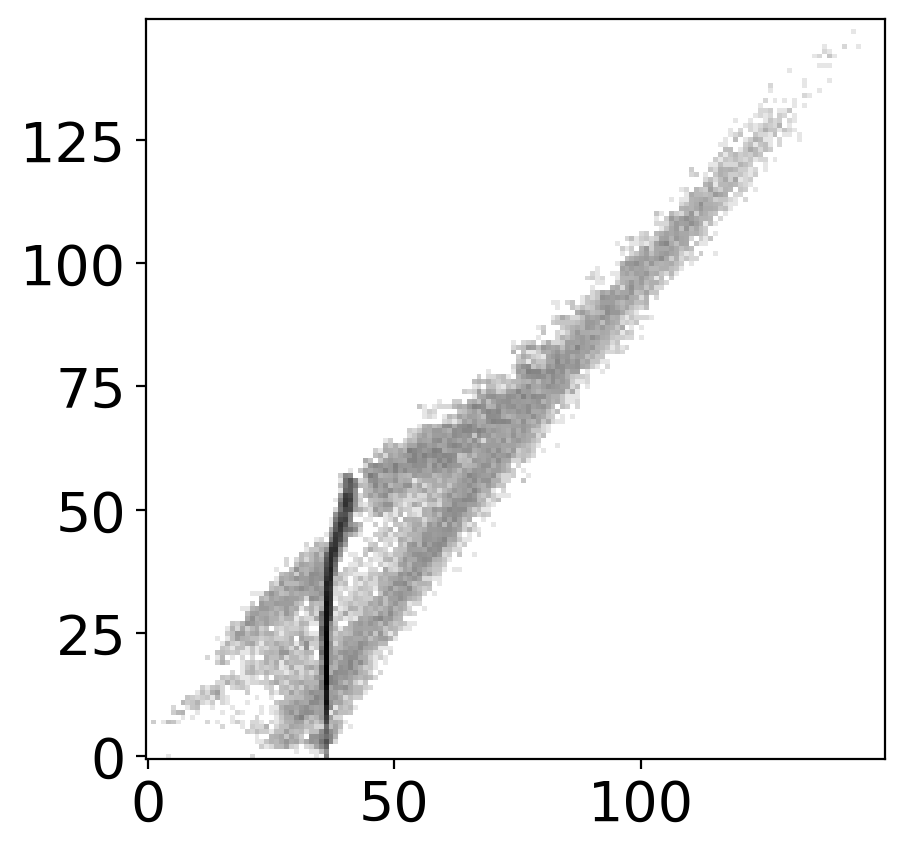

In [46]:
plt.imshow(np.log(Ju[0].T), 
          cmap='binary', 
          origin='lower')

## General Overview

- DiaSourceID (i.e look at light curves)
- From DiaSourceID to Source to look at the image/scinece/template

In [157]:

_tt = service.search(f"SELECT ra, decl, filterName, ccdVisitId "
                  "FROM dp02_dc2_catalogs.DiaSource "
                 "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                 f"CIRCLE('ICRS', {center_coords}, {rad})) = 1 "
                  f"AND diaObjectId = {1823562024899051852}").to_table()

In [197]:
_tt[31] # NOW WE WANT TO GO TO SOURCE!

ra,decl,filterName,ccdVisitId
deg,deg,,
float64,float64,object,int64
61.8244406,-32.8523807,i,479028093


In [208]:
#center_coords = "62, -32"
cc = "61.8244406, -32.8523807"
ff = "u"
_tt2 = service.search(f"SELECT ra, decl, coord_ra, coord_dec, ccdVisitId, "
                      "band, instrument, "
                      "visit, sourceId, detector "
                  "FROM dp02_dc2_catalogs.Source "
                 "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                 f"CIRCLE('ICRS', {cc}, {0.0003})) = 1 "
                  f"AND ccdVisitId = {479028093}").to_table()


In [209]:
_tt2

ra,decl,coord_ra,coord_dec,ccdVisitId,band,instrument,visit,sourceId,detector
deg,deg,deg,deg,,,,,,
float64,float64,float64,float64,int64,object,str13,int64,int64,int64
61.8243983,-32.852083,61.8243983,-32.852083,479028093,i,LSSTCam-imSim,479028,257176249162532979,93
61.8241736,-32.8524149,61.8241736,-32.8524149,479028093,i,LSSTCam-imSim,479028,257176249162532977,93


In [142]:
# midPointTai

In [153]:
targ = 1823562024899051852 # diaObjectID for some random source

In [154]:
# PLOT light curves!
ss = DiaSouceOID(targ, band='all') # Fetch DiaSource for this DiaObject...

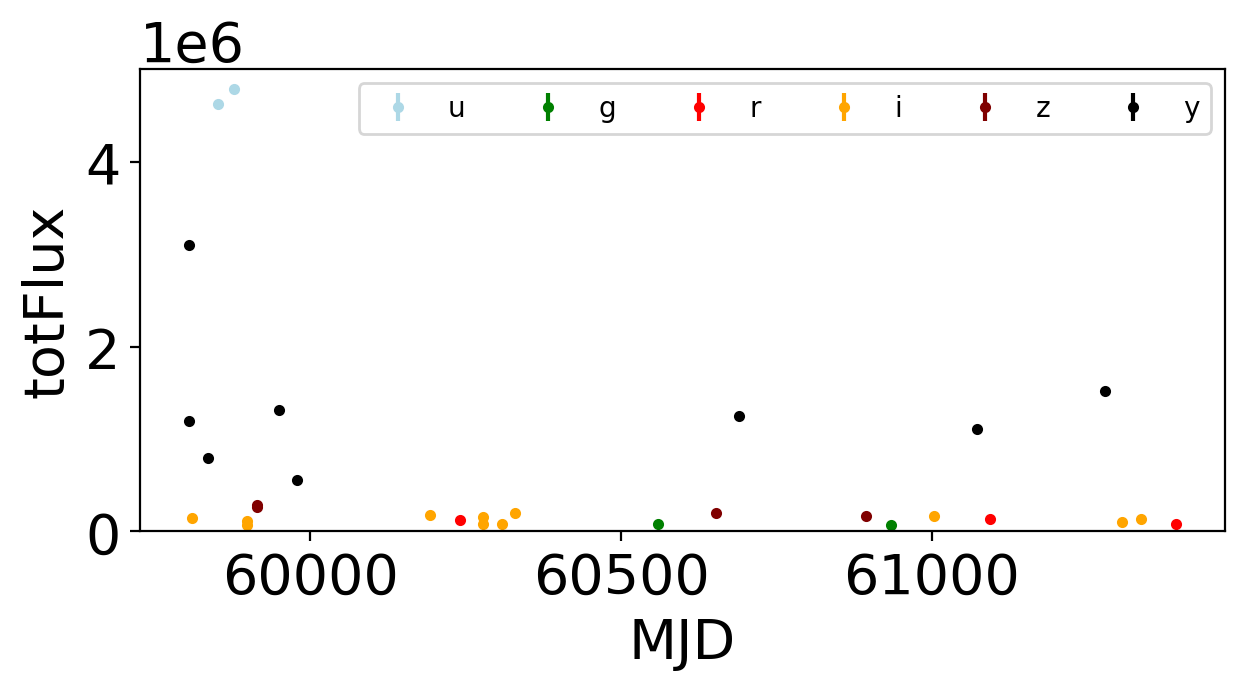

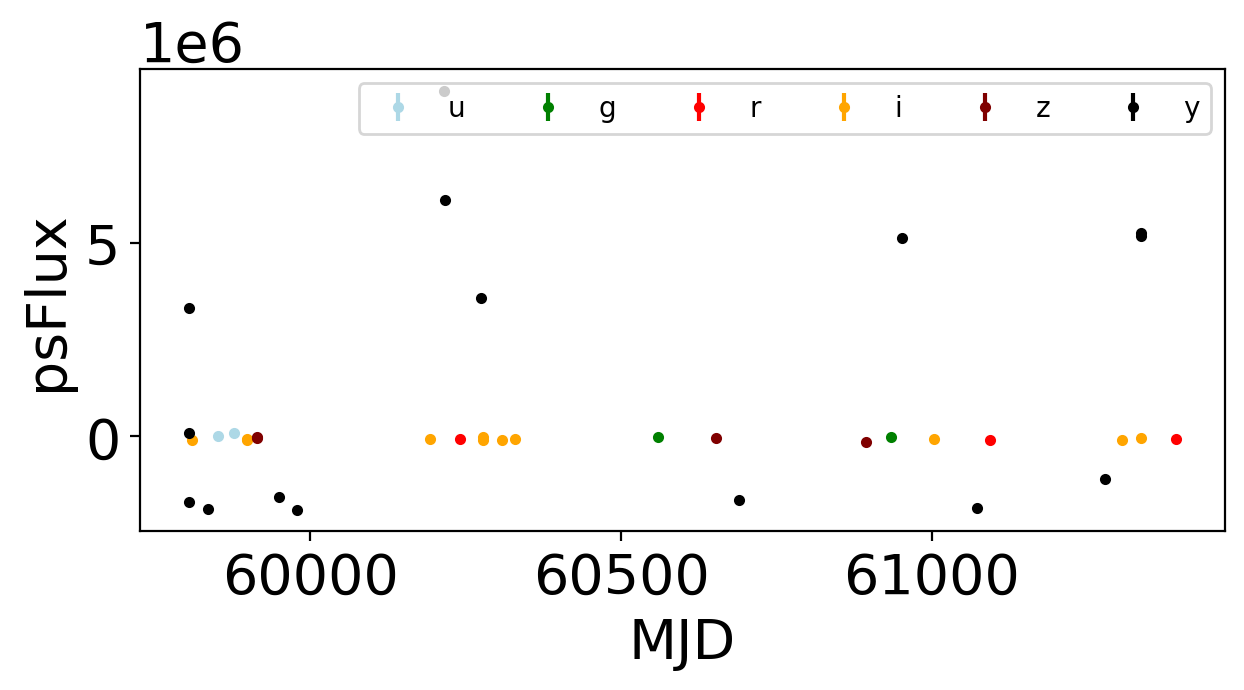

In [155]:
plt.figure(figsize=(7,3))
for ff in list('ugrizy'):
    filt_sel = ss['filterName']==ff
    
    if ff=='u':
        c = 'lightblue'
    if ff=='g':
        c = 'green'
    if ff=='r':
        c = 'red'
    if ff=='i':
        c = 'orange'
    if ff=='z':
        c = 'maroon'
    if ff=='y':
        c = 'k'
    
    plt.errorbar(ss['midPointTai'][filt_sel], ss['totFlux'][filt_sel], 
                 yerr=ss['totFluxErr'][filt_sel], 
                 fmt='.', color=c, 
                label=f'{ff}')
    plt.legend(ncols=6, fontsize=10)
    plt.ylim(0, 5e6)
    
    plt.xlabel('MJD')
    plt.ylabel('totFlux')
    
    
    
plt.figure(figsize=(7,3))
for ff in list('ugrizy'):
    filt_sel = ss['filterName']==ff
    
    if ff=='u':
        c = 'lightblue'
    if ff=='g':
        c = 'green'
    if ff=='r':
        c = 'red'
    if ff=='i':
        c = 'orange'
    if ff=='z':
        c = 'maroon'
    if ff=='y':
        c = 'k'
    
    plt.errorbar(ss['midPointTai'][filt_sel], ss['psFlux'][filt_sel], 
                 yerr=ss['totFluxErr'][filt_sel], 
                 fmt='.', color=c, 
                label=f'{ff}')
    plt.legend(ncols=6, fontsize=10)
    
    plt.ylabel('psFlux')
    plt.xlabel('MJD')              

band,ccdVisitId,coord_dec,coord_ra,diaObjectId,forcedSourceOnDiaObjectId,localBackground_instFlux,localBackground_instFluxErr,localPhotoCalib,localPhotoCalib_flag,localPhotoCalibErr,localWcs_CDMatrix_1_1,localWcs_CDMatrix_1_2,localWcs_CDMatrix_2_1,localWcs_CDMatrix_2_2,localWcs_flag,parentObjectId,patch,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,pixelFlags_edge,pixelFlags_interpolated,pixelFlags_interpolatedCenter,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,psfDiffFlux,psfDiffFlux_flag,psfDiffFluxErr,psfFlux,psfFlux_flag,psfFluxErr,skymap,tract
,,deg,deg,,,ct,ct,,,,,,,,,,,,,,,,,,,,,nJy,,nJy,nJy,,nJy,,
object,int64,float64,float64,int64,int64,float64,float64,float64,bool,float64,float64,float64,float64,float64,bool,int64,int64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,bool,float64,float64,bool,float64,str12,int64


<MaskedColumn name='psfFlux' dtype='float64' unit='nJy' description='Flux derived from linear least-squares fit of psf model forced on the calexp' length=0>

In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.patches as patches
import pandas as pd

from astropy import units as u
from astropy import visualization as aviz

import lsst.daf.butler as dafButler
import lsst.geom
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.decam import DarkEnergyCamera


In [4]:
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2') # call butler
registry = butler.registry # fetch registry

In [5]:
datasetRefs = registry.queryDatasets(datasetType='deepCoadd', band='r') # basic butler query 

In [210]:
!touch cutoutpipe.py

## Cutouts

In [12]:



@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def connectToApdb(dbName, dbType='sqlite', schema=None,
                  user="rubin", host="usdf-prompt-processing-dev.slac.stanford.edu"):
    """Connect to an sqlite or postgres APDB.

    Parameters
    ----------
    dbName : `str`
        If dbType is "sqlite", path to the APDB on the host.
        If dbType is "postgres", name of the APDB on the DB host machine.
    dbType : `str`, optional
        Either "sqlite" or "postgres".
    schema : `str`, optional
        Required if dbType is "postgres".
    user : `str`, optional
        Username to connect to postgres database with; only used for
        ``dbType="postgres"``.
    host: `str`, optional
        Hostname of postgres database to connect to; only used for
        ``dbType="postgres"``.

    Returns
    -------
    connection : `psycopg2.connect` or `sqlite3.Connection`
        A connection object to a database instance, ready for queries
    """
    if dbType == "sqlite":
        connection = sqlite3.connect(dbName)
    elif dbType == "postgres":
        if schema is None:
            raise RuntimeError('Schema must be set for postgres APDB')
        connection = psycopg2.connect(dbname=dbName,
                                      host=host,
                                      user=user,
                                      )
        cursor = connection.cursor()
        cursor.execute(sql.SQL("SET search_path TO {}").format(
            sql.Identifier(schema)))
    else:
        raise ValueError(f"dbType must be sqlite or postgres, not {dbType}")

    return connection


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def addTableMetadata(sourceTable, butler, instrument):
    """Add visit,detector,instrument columns to a DiaSource dataframe.

    Parameters
    ----------
    sourceTable : `pandas.core.frame.DataFrame`
        Pandas dataframe with DIA Sources from an APDB; modified in-place.
    butler : `lsst.daf.butler.Butler`
        Butler in the repository corresponding to the output of an ap_pipe run.
    instrument : `str`
        Short name (e.g. "DECam") of instrument to make a dataId unpacker
        and to add to the table columns; supports any gen3 instrument.

    Notes
    -----
    This function should be removed once the visit/detector/instrument columns
    are available from the APDB schema, and populated with the correct values.
    """
    if instrument is None:
        raise RuntimeError("Must specify instrument when expanding catalog metadata.")
    instrumentDataId = butler.registry.expandDataId(instrument=instrument)
    packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
    dataId = packer.unpack(sourceTable.ccdVisitId)
    sourceTable['visit'] = dataId['visit']
    sourceTable['detector'] = dataId['detector']
    sourceTable['instrument'] = instrument


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadSelectApdbSources(dbName, diaObjectId, dbType='sqlite', schema=None):
    """Load select columns from DIASources for a single DIAObject
    from an APDB into a pandas dataframe.

    Parameters
    ----------
    dbName : `str`
        If dbType is sqlite, full filepath to the APDB on lsst-dev.
        If dbType is postgres, name of the APDB on lsst-pg-devel1.
    diaObjectId : `int`
        DIA Object for which we want to retrieve constituent DIA Sources.
    dbType : `str`, optional
        Either 'sqlite' or 'postgres'
    schema : `str`, optional
        Required if dbType is postgres

    Returns
    -------
    srcTable : `pandas.DataFrame`
        DIA Source Table including the columns hard-wired below.
    """
    connection = connectToApdb(dbName, dbType, schema)

    # Load data from the source table
    srcTable = pd.read_sql_query('select "diaSourceId", "diaObjectId", \
                                  "ra", "decl", "ccdVisitId", "filterName", \
                                  "midPointTai", "apFlux", "psFlux", "apFluxErr", \
                                  "psFluxErr", "totFlux", "totFluxErr", "snr", "x", "y", \
                                  "ixxPSF", "iyyPSF", "ixyPSF", "flags" from {0}; \
                                  where "diaObjectId" = {1};'.format('"DiaSource"', diaObjectId), connection)
    return srcTable


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadExposures(butler, dataId, collections, diffName='deep'):
    """Load a science exposure, difference image, and warped template.

    Parameters
    ----------
    butler : `lsst.daf.butler.Butler`
        Butler in the repository corresponding to the output of an ap_pipe run.
    dataId : `dict`-like
        Gen3 data ID specifying at least instrument, visit, and detector.
    collections : `str` or `list`
        Gen3 collection or collections from which to load the exposures.
    diffName : `str`, optional
        Default is 'deep', but 'goodSeeing' may be needed instead.

    Returns
    -------
    science : `lsst.afw.Exposure`
        calexp corresponding to dataId and collections.
    difference : `lsst.afw.Exposure`
        differenceExp corresponding to dataId and collections.
    template : `lsst.afw.Exposure`
        warpedExp corresponding to dataId and collections.
    """
    science = butler.get('calexp', dataId=dataId, collections=collections)
    difference = butler.get(diffName + 'Diff_differenceExp', dataId=dataId, collections=collections)
    template = butler.get(diffName + 'Diff_templateExp', dataId=dataId, collections=collections)
    return science, difference, template


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadTables(repo, dbName='association.db', isVerify=False, dbType='sqlite',
               badFlagList=['base_PixelFlags_flag_bad',
                            'base_PixelFlags_flag_suspect',
                            'base_PixelFlags_flag_saturatedCenter',
                            'base_PixelFlags_flag_interpolated',
                            'base_PixelFlags_flag_interpolatedCenter',
                            'base_PixelFlags_flag_edge',
                            ],
               instrument=None, schema=None, allCol=False):
    """Load DIA Object and DIA Source tables from an APDB.

    Parameters
    ----------
    repo : `str`
        Repository corresponding to the output of an ap_pipe run.
    dbName : `str`
        Name of APDB.
    isVerify : `bool`
        Is this an ap_verify run instead of an ap_pipe run?
        If True, the APDB is one level above repo on disk.
        If False, the APDB is in repo (default).
    dbType : `str`, optional
        Either 'sqlite' or 'postgres'
    badFlagList :  `list`
        Names of flags presumed to each indicate a DIA
        Source is garbage.
    instrument : `str`, either 'DECam' or 'HSC', default is 'DECam'
        Needed to properly add the "ccd" and "visit" columns
        to the sourceTable, and for all things gen3
    schema : `str`, optional
        Required if dbType is postgres
    allCol : `bool`, optional
        If True, load ALL columns of data

    Returns
    -------
    objTable : `pandas.core.frame.DataFrame`
        DIA Object table loaded from the APDB.
    srcTable : `pandas.core.frame.DataFrame`
        DIA Source table loaded from the APDB.
    goodObj : `pandas.core.frame.DataFrame`
        A subset of objTable containing only DIA Objects composed
    entirely of good DIA Sources.
    goodSrc : `pandas.core.frame.DataFrame`
        A subset of srcTable containing only good DIA Sources.
    """
    if dbType == 'sqlite' and not isVerify:  # APDB is in repo (default)
        dbPath = os.path.abspath(os.path.join(repo, dbName))
    elif dbType == 'sqlite' and isVerify:  # APDB is one level above repo (ap_verify sqlite case)
        repoUpOne = os.path.dirname(repo)
        dbPath = os.path.abspath(os.path.join(repoUpOne, dbName))
    elif dbType == 'postgres':
        dbPath = dbName
    else:
        raise ValueError('database type not understood')

    butler = dafButler.Butler(repo)

    objTable = loadAllApdbObjects(dbPath, dbType=dbType,
                                  schema=schema, allCol=allCol)
    srcTable = loadAllApdbSources(dbPath, dbType=dbType,
                                  schema=schema, allCol=allCol)
    addTableMetadata(srcTable, butler=butler, instrument=instrument)
    flagTable, srcTableFlags, flagFilter, \
        goodSrc, goodObj = makeSrcTableFlags(srcTable, objTable, badFlagList=badFlagList,
                                             instrument=instrument, repo=repo)
    return objTable, srcTable, goodObj, goodSrc


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadTablesByVisit(repo, visit, dbName='association.db', isVerify=False,
                      dbType='sqlite',
                      badFlagList=['base_PixelFlags_flag_bad',
                                   'base_PixelFlags_flag_suspect',
                                   'base_PixelFlags_flag_saturatedCenter',
                                   'base_PixelFlags_flag_interpolated',
                                   'base_PixelFlags_flag_interpolatedCenter',
                                   'base_PixelFlags_flag_edge',
                                   ],
                      instrument=None, schema=None):
    """Load DIA Object and DIA Source tables from an APDB.

    Parameters
    ----------
    repo : `str`
        Repository corresponding to the output of an ap_pipe run.
    visit: `int`
        Visit number
    dbName : `str`
        Name of APDB.
    isVerify : `bool`
        Is this an ap_verify run instead of an ap_pipe run?
        If True, the APDB is one level above repo on disk.
        If False, the APDB is in repo (default).
    dbType : `str`, optional
        Either 'sqlite' or 'postgres'
    badFlagList :  `list`
        Names of flags presumed to each indicate a DIA Source is garbage.
    instrument : `str`, one of either 'DECam' or 'HSC', default is 'DECam'
        Needed to properly add the "ccd" and "visit" columns to
    the sourceTable, and for all things gen3
    schema : `str`, optional
        Required if dbType is postgres

    Returns
    -------
    objTable : `pandas.core.frame.DataFrame`
        DIA Object table loaded from the APDB.
    srcTable : `pandas.core.frame.DataFrame`
        DIA Source table loaded from the APDB.
    goodObj : `pandas.core.frame.DataFrame`
        A subset of objTable containing only DIA Objects composed entirely of
        good DIA Sources.
    goodSrc : `pandas.core.frame.DataFrame`
        A subset of srcTable containing only good DIA Sources.
    """

    if dbType == 'sqlite' and not isVerify:  # APDB is in repo (default)
        dbPath = os.path.abspath(os.path.join(repo, dbName))
    elif dbType == 'sqlite' and isVerify:  # APDB is one level above repo (ap_verify sqlite case)
        repoUpOne = os.path.dirname(repo)
        dbPath = os.path.abspath(os.path.join(repoUpOne, dbName))
    elif dbType == 'postgres':
        dbPath = dbName
    else:
        raise ValueError('database type not understood')

    butler = dafButler.Butler(repo)

    objTable = loadAllApdbObjects(dbPath, dbType=dbType, schema=schema)
    srcTable = loadApdbSourcesByVisit(dbPath, visit, dbType=dbType, schema=schema)
    addTableMetadata(srcTable, butler=butler, instrument=instrument)
    flagTable, srcTableFlags, flagFilter, \
        goodSrc, goodObj = makeSrcTableFlags(srcTable, objTable, badFlagList=badFlagList,
                                             instrument=instrument, repo=repo)
    return objTable, srcTable, goodObj, goodSrc


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadTablesByBand(repo, band, dbName='association.db', isVerify=False,
                     dbType='sqlite',
                     badFlagList=['base_PixelFlags_flag_bad',
                                  'base_PixelFlags_flag_suspect',
                                  'base_PixelFlags_flag_saturatedCenter',
                                  'base_PixelFlags_flag_interpolated',
                                  'base_PixelFlags_flag_interpolatedCenter',
                                  'base_PixelFlags_flag_edge',
                                  ],
                     instrument=None, schema=None):
    """Load DIA Object and DIA Source tables from an APDB.

    Parameters
    ----------
    repo : `str`
        Repository corresponding to the output of an ap_pipe run.
    band: `str`
        Band to match against filterName in DB
    dbName : `str`
        Name of APDB.
    isVerify : `bool`
        Is this an ap_verify run instead of an ap_pipe run?
        If True, the APDB is one level above repo on disk.
        If False, the APDB is in repo (default).
    dbType : `str`, optional
        Either 'sqlite' or 'postgres'
    badFlagList :  `list`
        Names of flags presumed to each indicate a DIA Source is garbage.
    instrument : `str`, one of either 'DECam' or 'HSC', default is 'DECam'
        Needed to properly add the "ccd" and "visit" columns to the
        sourceTable, and for all things gen3.
    schema : `str`, optional
        Required if dbType is postgres

    Returns
    -------
    objTable : `pandas.core.frame.DataFrame`
        DIA Object table loaded from the APDB.
    srcTable : `pandas.core.frame.DataFrame`
        DIA Source table loaded from the APDB.
    goodObj : `pandas.core.frame.DataFrame`
        A subset of objTable containing only DIA Objects composed entirely of
        good DIA Sources.
    goodSrc : `pandas.core.frame.DataFrame`
        A subset of srcTable containing only good DIA Sources.
    """
    if dbType == 'sqlite' and not isVerify:  # APDB is in repo (default)
        dbPath = os.path.abspath(os.path.join(repo, dbName))
    # APDB is one level above repo (ap_verify sqlite case)
    elif dbType == 'sqlite' and isVerify:
        repoUpOne = os.path.dirname(repo)
        dbPath = os.path.abspath(os.path.join(repoUpOne, dbName))
    elif dbType == 'postgres':
        dbPath = dbName
    else:
        raise ValueError('database type not understood')

    butler = dafButler.Butler(repo)

    objTable = loadAllApdbObjects(dbPath, dbType=dbType, schema=schema)
    srcTable = loadApdbSourcesByBand(dbPath, band, dbType=dbType, schema=schema)
    addTableMetadata(srcTable, butler=butler, instrument=instrument)
    flagTable, srcTableFlags, flagFilter, \
        goodSrc, goodObj = makeSrcTableFlags(srcTable, objTable, badFlagList=badFlagList,
                                             instrument=instrument, repo=repo)
    return objTable, srcTable, goodObj, goodSrc


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def makeSrcTableFlags(sourceTable, objectTable,
                      badFlagList=['base_PixelFlags_flag_bad',
                                   'base_PixelFlags_flag_suspect',
                                   'base_PixelFlags_flag_saturatedCenter',
                                   'base_PixelFlags_flag_interpolated',
                                   'base_PixelFlags_flag_interpolatedCenter',
                                   'base_PixelFlags_flag_edge',
                                   ],
                      instrument=None, repo=None):
    """Apply flag filters to a DIA Source and a DIA Object table.

    Parameters
    ----------
    sourceTable : `pandas.core.frame.DataFrame`
        Pandas dataframe with DIA Sources from an APDB.
    objectTable : `pandas.core.frame.DataFrame`
        Pandas dataframe with DIA Objects from the same APDB.
    badFlagList :  `list`
        Names of flags presumed to each indicate a DIA Source is garbage.
     instrument : `str`
        Default is 'DECam'
    repo : `str`
        Repository in which to load a butler

    Returns
    -------
    flagTable : `pandas.core.frame.DataFrame`
        Dataframe containing unpacked DIA Source flag values.
    sourceTableFlags : `pandas.core.frame.DataFrame`
        Dataframe resulting from from merging sourceTable with flagTable.
    flagFilter : `pandas.core.series.Series` of `bool`
        Single column of booleans of length len(sourceTable).
        The value of flagFilter is True if one or more flags
        in badFlagList is True.
    goodSrc : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Sources from sourceTable
        with no bad flags.
    goodObj : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Objects from objectTable
        entirely composed of DIA Sources with no bad flags.
    """
    butler = dafButler.Butler(repo)
    addTableMetadata(sourceTable, butler=butler, instrument=instrument)
    config = TransformDiaSourceCatalogConfig()
    unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
    flagValues = unpacker.unpack(sourceTable['flags'], 'flags')
    flagTable = pd.DataFrame(flagValues, index=sourceTable.index)
    sourceTableFlags = pd.merge(sourceTable, flagTable, left_index=True, right_index=True)
    badFlags = [sourceTableFlags[flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter
    goodSrc = sourceTableFlags.loc[noFlagFilter]
    goodObjIds = set(sourceTableFlags.loc[noFlagFilter, 'diaObjectId'])
    goodObj = objectTable.loc[objectTable['diaObjectId'].isin(goodObjIds)]
    return flagTable, sourceTableFlags, flagFilter, goodSrc, goodObj


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadAllApdbObjects(dbName, dbType='sqlite', schema=None, allCol=False):
    """Load a subset of DIAObject columns from a APDB into a pandas dataframe.

    Parameters
    ----------
    dbName : `str`
        If dbType is sqlite, *full path* to the APDB on lsst-dev.
        If dbType is postgres, name of the APDB on lsst-pg-devel1.
    dbType : `str`, optional
        Either 'sqlite' or 'postgres'
    schema : `str`, optional
        Required if dbType is postgres
    allCol : `bool`, optional
        If True, load ALL columns of data

    Returns
    -------
    objTable : `pandas.DataFrame`
        DIA Object Table containing only objects with validityEnd NULL.
        Columns selected are presently hard-wired here.
    """
    connection = connectToApdb(dbName, dbType, schema)

    # Only get objects with validityEnd NULL as they are still valid
    if not allCol:
        objTable = pd.read_sql_query('select "diaObjectId", "ra", "decl", "nDiaSources", \
                                    "gPSFluxMean", "rPSFluxMean", "iPSFluxMean", \
                                    "zPSFluxMean", "yPSFluxMean", "validityEnd", "flags" from {0} \
                                    where "validityEnd" is NULL;'.format('"DiaObject"'), connection)
    else:
        objTable = pd.read_sql_query('select * from {0} where "validityEnd" is NULL; \
                                     '.format('"DiaObject"'), connection)
    return objTable


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadAllApdbSources(dbName, dbType='sqlite', schema=None, allCol=False):
    """Load a subset of columns from all DIASources from an APDB
       into a pandas dataframe.

    Parameters
    ----------
    dbName : `str`
        If dbType is sqlite, full filepath to the APDB on lsst-dev.
        If dbType is postgres, name of the APDB on lsst-pg-devel1.
    dbType : `str`, optional
        Either 'sqlite' or 'postgres'
    schema : `str`, optional
        Required if dbType is postgres
    allCol : `bool`, optional
        If True, load ALL columns of data

    Returns
    -------
    srcTable : `pandas.DataFrame`
        DIA Source Table including the columns hard-wired below.
    """
    connection = connectToApdb(dbName, dbType, schema)

    # Load data from the source table
    if not allCol:
        srcTable = pd.read_sql_query('select "diaSourceId", "diaObjectId", \
                                    "ra", "decl", "ccdVisitId", \
                                    "midPointTai", "apFlux", "psFlux", "apFluxErr", \
                                    "psFluxErr", "totFlux", "totFluxErr", "snr", "x", "y", \
                                    "ixxPSF", "iyyPSF", "ixyPSF", "flags", "filterName" from {0}; \
                                    '.format('"DiaSource"'), connection)
    else:
        srcTable = pd.read_sql_query('select * from {0}; \
                                     '.format('"DiaSource"'), connection)
    return srcTable


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadAllApdbForcedSources(dbName, dbType='sqlite', schema=None, allCol=False):
    """Load columns from all ForcedDiaSources from a APDB
    into a pandas dataframe.

    Parameters
    ----------
    dbName : `str`
        If dbType is sqlite, full filepath to the APDB.
        If dbType is postgres, name of the APDB on the host.
    dbType : `str`, optional
        Either 'sqlite' or 'postgres'
    schema : `str`, optional
        Required if dbType is postgres
    allCol : `bool`, optional
        If True, load ALL columns of data

    Returns
    -------
    srcTable : `pandas.DataFrame`
        DIA Source Table including the columns hard-wired below,
        or all columns if allCol is set to True.
    """
    connection = connectToApdb(dbName, dbType, schema)

    # Load data from the forced source table
    if not allCol:
        forcedSrcTable = pd.read_sql_query('select "diaSourceId", "diaObjectId", \
                                        "ra", "decl", "ccdVisitId", \
                                        "midPointTai", "apFlux", "psFlux", "apFluxErr", \
                                        "psFluxErr", "totFlux", "totFluxErr", "snr", "x", "y", \
                                        "ixxPSF", "iyyPSF", "ixyPSF", "flags", "filterName" from {0}; \
                                        '.format('"DiaForcedSource"'), connection)
    else:
        forcedSrcTable = pd.read_sql_query('select * from {0}; \
                                        '.format('"DiaForcedSource"'), connection)
    return forcedSrcTable


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadApdbSourcesByVisit(dbName, visit, dbType='sqlite', schema=None):
    """Load a subset of columns from all DIASources from an APDB
       into a pandas dataframe.

    Parameters
    ----------
    dbName : `str`
        If dbType is sqlite, full filepath to the APDB on lsst-dev.
        If dbType is postgres, name of the APDB on lsst-pg-devel1.
    dbType : `str`, optional
        Either 'sqlite' or 'postgres'
    schema : `str`, optional
        Required if dbType is postgres
    visit : `int`
        Visit number for loading objects

    Returns
    -------
    srcTable : `pandas.DataFrame`
        DIA Source Table including the columns hard-wired below.
    """
    connection = connectToApdb(dbName, dbType, schema)
    # Load data from the source table
    srcTable = pd.read_sql_query('select "diaSourceId", "diaObjectId", \
                                  "ra", "decl", "ccdVisitId", \
                                  "midPointTai", "apFlux", "psFlux", "apFluxErr", \
                                  "psFluxErr", "totFlux", "totFluxErr", "snr", "x", "y", \
                                  "ixxPSF", "iyyPSF", "ixyPSF", "flags", "filterName" from {0} \
                                   where CAST("ccdVisitId" as text) like {1} ; \
                                  '.format('"DiaSource"', "'"+str(int(visit))+"%'"), connection)
    return srcTable


@deprecated(reason="This method is deprecated and will be removed once the "
                   "replacement API is in place.", version="v24", category=FutureWarning)
def loadApdbSourcesByBand(dbName, band, dbType='sqlite', schema=None):
    """Load a subset of columns from all DIASources from an APDB
       into a pandas dataframe.

    Parameters
    ----------
    dbName : `str`
        If dbType is sqlite, full filepath to the APDB on lsst-dev.
        If dbType is postgres, name of the APDB on lsst-pg-devel1.
    dbType : `str`, optional
        Either 'sqlite' or 'postgres'
    schema : `str`, optional
        Required if dbType is postgres
    band : `str`
        Band for loading objects (matched against filterName)

    Returns
    -------
    srcTable : `pandas.DataFrame`
        DIA Source Table including the columns hard-wired below.
    """
    connection = connectToApdb(dbName, dbType, schema)
    # Load data from the source table
    srcTable = pd.read_sql_query('select "diaSourceId", "diaObjectId", \
                                  "ra", "decl", "ccdVisitId", \
                                  "midPointTai", "apFlux", "psFlux", \
                                  "apFluxErr", "psFluxErr", "totFlux", \
                                  "totFluxErr", "snr", "x", "y", "ixxPSF", \
                                  "iyyPSF", "ixyPSF", "flags", "filterName" \
                                  from {0} where "filterName" = {1} ; \
                                  '.format('"DiaSource"', "'"+band+"'"),
                                 connection)
    return srcTable

In [45]:
dii = {"band": 'r', "instrument": 'HSC', "detector": 41, "physical_filter": 'HSC-R', "visit_system": 0, "visit": 23718}

In [46]:
#import getpass
#my_username = getpass.getuser()

#my_collection_identifier = 'custom_coadd_1'

#my_outputCollection = 'u/'+my_username+'/'+my_collection_identifier

In [138]:
def retrieveCutouts(butler, dataId, collections, center, size=lsst.geom.Extent2I(30, 30), diffName='goodSeeing'):
    """Return small cutout exposures for a science exposure, difference image,
    and warped template.

    Parameters
    ----------
    butler : `lsst.daf.butler.Butler`
        Butler in the repository corresponding to the output of an ap_pipe run.
    dataId : `dict`-like
        Gen3 data ID specifying at least instrument, visit, and detector.
    collections : `str` or `list`
        Gen3 collection or collections from which to load the exposures.
    center : `lsst.geom.SpherePoint`
        Desired center coordinate of cutout.
    size : `lsst.geom.Extent`, optional
        Desired size of cutout, default is 30x30 pixels
    diffName : `str`, optional
        Default is 'deep', but 'goodSeeing' may be needed instead.

    Returns
    -------
    scienceCutout : `lsst.afw.Exposure`
        Cutout of calexp at location 'center' of size 'size'.
    differenceCutout : `lsst.afw.Exposure`
        Cutout of diffName_differenceExp at location 'center' of size 'size'.
    templateCutout : `lsst.afw.Exposure`
        Cutout of diffName_templateExp at location 'center' of size 'size'.
    """
    science, difference, template = loadExposures(butler, dataId,
                                              collections, diffName)
    scienceCutout = science.getCutout(center, size)
    differenceCutout = difference.getCutout(center, size)
    templateCutout = template.getCutout(center, size)
    return scienceCutout, differenceCutout, templateCutout


def plotCutout(scienceCutout, differenceCutout, templateCutout, output=None):
    """Plot the cutouts for one DIASource in one image.

    Parameters
    ----------
    scienceCutout : `lsst.afw.Exposure`
        Cutout of calexp returned by retrieveCutouts.
    differenceCutout : `lsst.afw.Exposure`
        Cutout of deepDiff_differenceExp returned by retrieveCutouts.
    templateCutout : `lsst.afw.Exposure`
        Cutout of deepDiff_templateExp returned by retrieveCutouts.
    output : `str`, optional
        If provided, save png to disk at output filepath.
    """
    def do_one(ax, data, name):
        interval = aviz.ZScaleInterval()
        if name == 'Difference':
            norm = aviz.ImageNormalize(data, stretch=aviz.LinearStretch())
        else:
            norm = aviz.ImageNormalize(data, interval=interval, stretch=aviz.AsinhStretch(a=0.1))
        ax.imshow(data, cmap=cm.bone, interpolation="none",norm=norm)
                  #vmin=np.mean(data)-2*np.std(data)*np.mean(data),
                 #vmax=np.mean(data)+2*np.std(data)*np.mean(data))
        ax.axis('off')
        ax.set_title(name)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    do_one(ax1, templateCutout.image.array, "Template")
    do_one(ax2, scienceCutout.image.array, "Science")
    do_one(ax3, differenceCutout.image.array, "Difference")
    plt.tight_layout()

    if output is not None:
        plt.savefig(output, bbox_inches="tight")
        plt.close()


In [83]:
rad = 0.01 # radius of cone search

res = service.search("SELECT ra, decl, coord_ra, coord_dec, ccdVisitId, "
                     "band, instrument, "
                     "visit, sourceId, detector "
                         "FROM dp02_dc2_catalogs.Source "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {rad})) = 1")

t0 = res.to_table()

ra,decl,coord_ra,coord_dec,ccdVisitId,band,instrument,visit,sourceId,detector
deg,deg,deg,deg,,,,,,
float64,float64,float64,float64,int64,object,str13,int64,int64,int64
62.0015258,-32.006862,62.0015258,-32.006862,410987023,i,LSSTCam-imSim,410987,220646977858176503,23


In [117]:
index = 12

ema = {"visit": t0['visit'][index], "band": t0['band'][index], "instrument":t0['instrument'][index], "detector":t0['detector'][index]}
my_spherePoint = lsst.geom.SpherePoint(t0['ra'][index]*lsst.geom.degrees, t0['decl'][index]*lsst.geom.degrees)


/tmp/ipykernel_3024/846067396.py:29: FutureWarning: Call to deprecated function (or staticmethod) loadExposures. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  science, difference, template = loadExposures(butler, dataId,


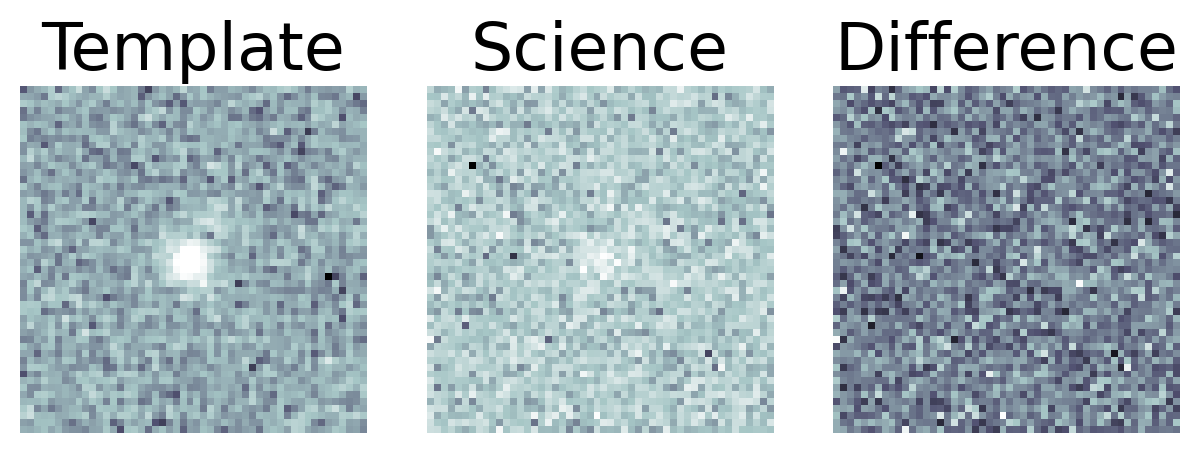

In [139]:
outp = retrieveCutouts(butler, ema, '2.2i/runs/DP0.2', my_spherePoint, lsst.geom.Extent2I(50, 50))
plotCutout(*outp)